In [13]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import zipfile
import shutil
import warnings
from typing import List
from typing import Tuple
from CNN_helper_function import get_labels, eval_model

warnings.filterwarnings('ignore')

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D, Rescaling, RandomFlip, RandomRotation 

from tensorflow.keras.models import load_model

print(f"Tensorflow Version: {tf.__version__}")

# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

seed = 42
tf.random.set_seed(seed)

Tensorflow Version: 2.15.0


Found 19675 files belonging to 2 classes.


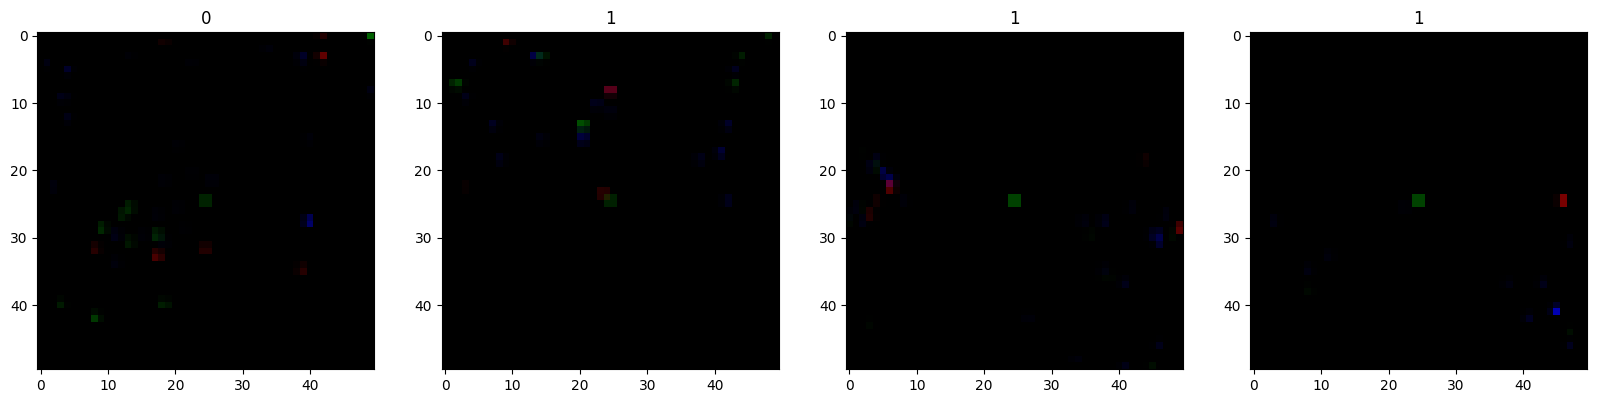

In [14]:
data_dir = '/teamspace/studios/this_studio/all/EFlow Images/rgb_images_data'

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   seed=seed,
                                                   batch_size = 70,
                                                   image_size = (50,50))

scaled_data = data.map(lambda x, y: (x/255, y))

data_iterator = scaled_data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [15]:
train_size = int(len(data)*.7) #70% of total batches as training data
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [23]:
#Defining data augmentation layers
data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.5),
])

In [24]:
def prepare(ds, shuffle=False, augment=False):
    '''
    Performs preprocessing steps on the passed dataset.
    '''
    if shuffle:
        ds = ds.shuffle(1000)
    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
            
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
train = prepare(train, augment = True)
val = prepare(val)
test = prepare(test)

In [26]:
train_data = train.as_numpy_iterator()
batch = train_data.next()

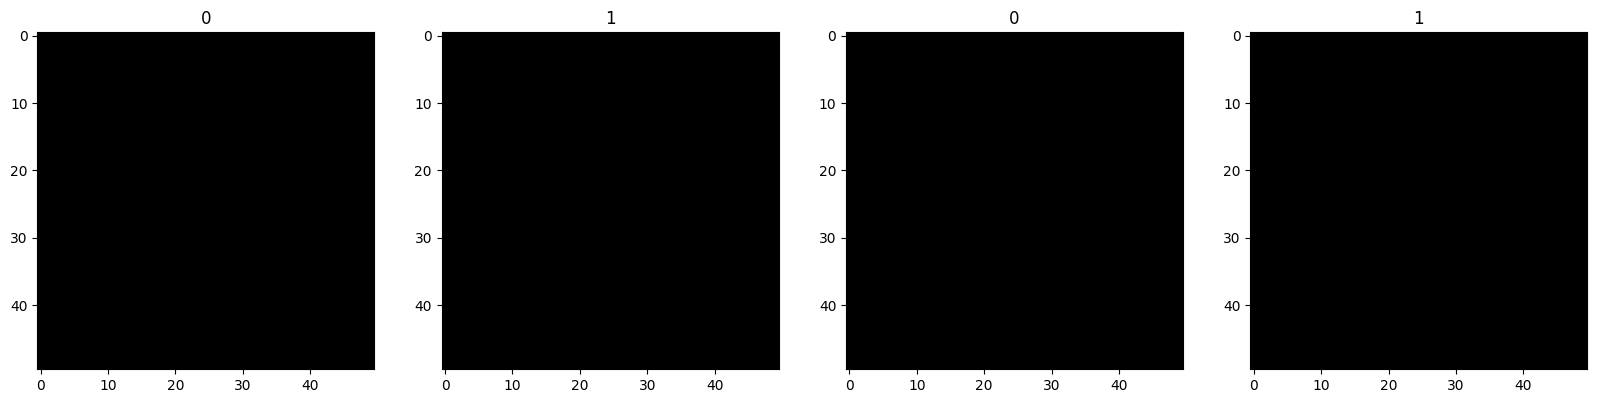

In [27]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..108.01907].


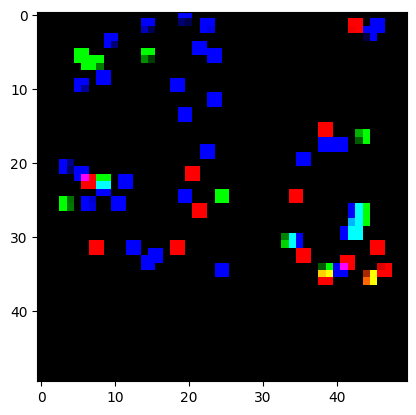

In [28]:
data_batch = data.as_numpy_iterator().next()
sample_img =data_batch[0][4]
plt.imshow(sample_img)
plt.show()

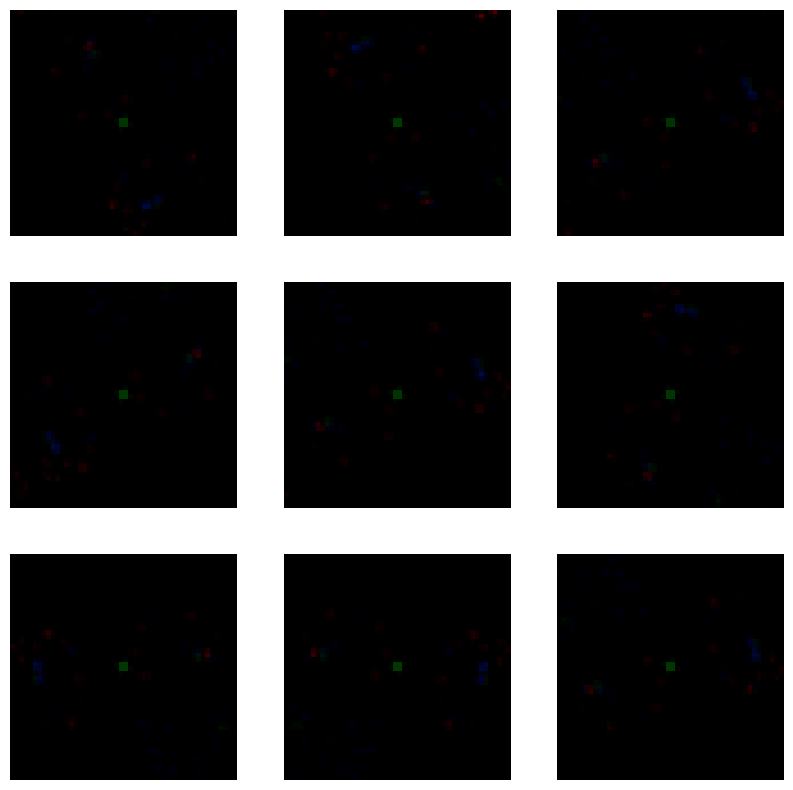

In [29]:
#Augmented sample_img
image = tf.cast(tf.expand_dims(sample_img, 0), tf.float32)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

# Model

In [30]:
AugData_model = Sequential()

AugData_model.add(Conv2D(128, (5,5), 1, padding = 'same', activation='relu', input_shape=(50,50,3)))
AugData_model.add(AveragePooling2D(pool_size = (2,2),strides=1)) #2x2 filter

AugData_model.add(Conv2D(256, (3,3), 1, activation='relu'))
AugData_model.add(AveragePooling2D(pool_size = (2,2)))

AugData_model.add(Conv2D(64, (3,3), 1, activation='relu'))
AugData_model.add(AveragePooling2D(pool_size = (2,2), strides=1,
                        padding='same'))

AugData_model.add(Conv2D(16, (2,2), 1, activation='relu'))
AugData_model.add(AveragePooling2D(pool_size = (2,2)))

AugData_model.add(Conv2D(8, (2,2), 1, activation='relu'))
AugData_model.add(AveragePooling2D(pool_size = (2,2)))

AugData_model.add(Flatten())

AugData_model.add(Dense(256, activation='relu'))
AugData_model.add(Dense(512, activation='relu'))
AugData_model.add(Dense(1, activation='sigmoid'))

In [31]:
AugData_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 50, 50, 128)       9728      
                                                                 
 average_pooling2d_5 (Avera  (None, 49, 49, 128)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_6 (Conv2D)           (None, 47, 47, 256)       295168    
                                                                 
 average_pooling2d_6 (Avera  (None, 23, 23, 256)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        147520    
                                                                 
 average_pooling2d_7 (Avera  (None, 21, 21, 64)       

In [32]:
AugData_model.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

In [33]:
logdir = '/teamspace/studios/this_studio/all/EFlow Images/model_tensorboard_logs/Classifier_with_DataAugmentation_model_logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = AugData_model.fit(train,
                 epochs = 30,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/30


2025-02-02 17:07:26.171695: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900
2025-02-02 17:07:29.950933: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbf581fb930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-02 17:07:29.950976: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-02-02 17:07:29.976707: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738516050.146567    5567 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 [==============================] - 23s 63ms/step - loss: 0.6933 - accuracy: 0.5029 - precision_1: 0.4987 - recall_1: 0.2457 - auc_1: 0.4992 - true_positives_1: 1682.0000 - false_positives_1: 1691.0000 - true_negatives_1: 5253.0000 - false_negatives_1: 5164.0000 - val_loss: 0.6949 - val_accuracy: 0.4855 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.4550 - val_true_positives_1: 0.0000e+00 - val_false_positives_1: 0.0000e+00 - val_true_negatives_1: 1903.0000 - val_false_negatives_1: 2017.0000
Epoch 2/30
197/197 [==============================] - 12s 60ms/step - loss: 0.6932 - accuracy: 0.5009 - precision_1: 0.4891 - recall_1: 0.1704 - auc_1: 0.4938 - true_positives_1: 1164.0000 - false_positives_1: 1216.0000 - true_negatives_1: 5744.0000 - false_negatives_1: 5666.0000 - val_loss: 0.6950 - val_accuracy: 0.4847 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.4510 - val_true_positives_1: 0.0000e+00 - val_false_positives_1: 0.0000e+00 

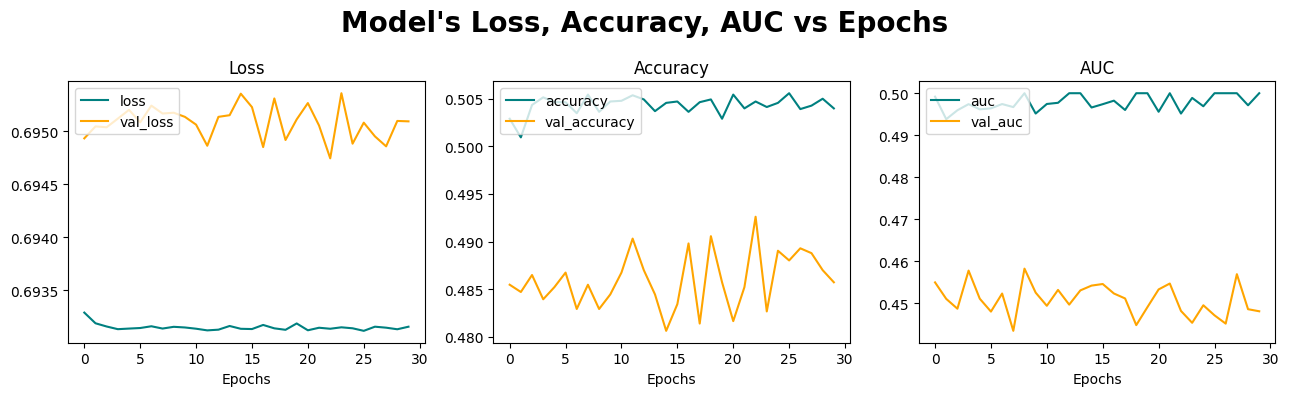

In [34]:
fig, axs = plt.subplots(1, 3, figsize = (13,4))

# Loss Plot
axs[0].plot(hist.history['loss'], color='teal', label='loss')
axs[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Loss')
axs[0].legend(loc="upper left")

# Accuracy Plot
axs[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Accuracy')
axs[1].legend(loc="upper left")

# AUC Plot
axs[2].plot(hist.history['auc_1'], color='teal', label='auc')
axs[2].plot(hist.history['val_auc_1'], color='orange', label='val_auc')
axs[2].set_xlabel('Epochs')
axs[2].set_title('AUC')
axs[2].legend(loc="upper left")

plt.suptitle("Model's Loss, Accuracy, AUC vs Epochs", fontsize = 20, fontweight = 'bold')
plt.tight_layout()
# plt.savefig('Classifier_with_DataAugmentation_model_trainingMetrics.png', dpi = 300)
plt.show()

In [38]:
test_evaluate = AugData_model.evaluate(test)

28/28 [==============================] - 1s 19ms/step - loss: 0.6949 - accuracy: 0.4918 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_1: 0.4371 - true_positives_1: 0.0000e+00 - false_positives_1: 0.0000e+00 - true_negatives_1: 964.0000 - false_negatives_1: 996.0000


In [39]:
print(f"Best Obtained Loss: {hist.history['loss'][-1]}\n\
Best Obtained Accuracy: {hist.history['accuracy'][-1]*100:.2f}%\n\
Best Obtained Validation Accuracy: {hist.history['val_accuracy'][-1]*100:.2f}%")

Best Obtained Loss: 0.6931549310684204
Best Obtained Accuracy: 50.40%
Best Obtained Validation Accuracy: 48.57%


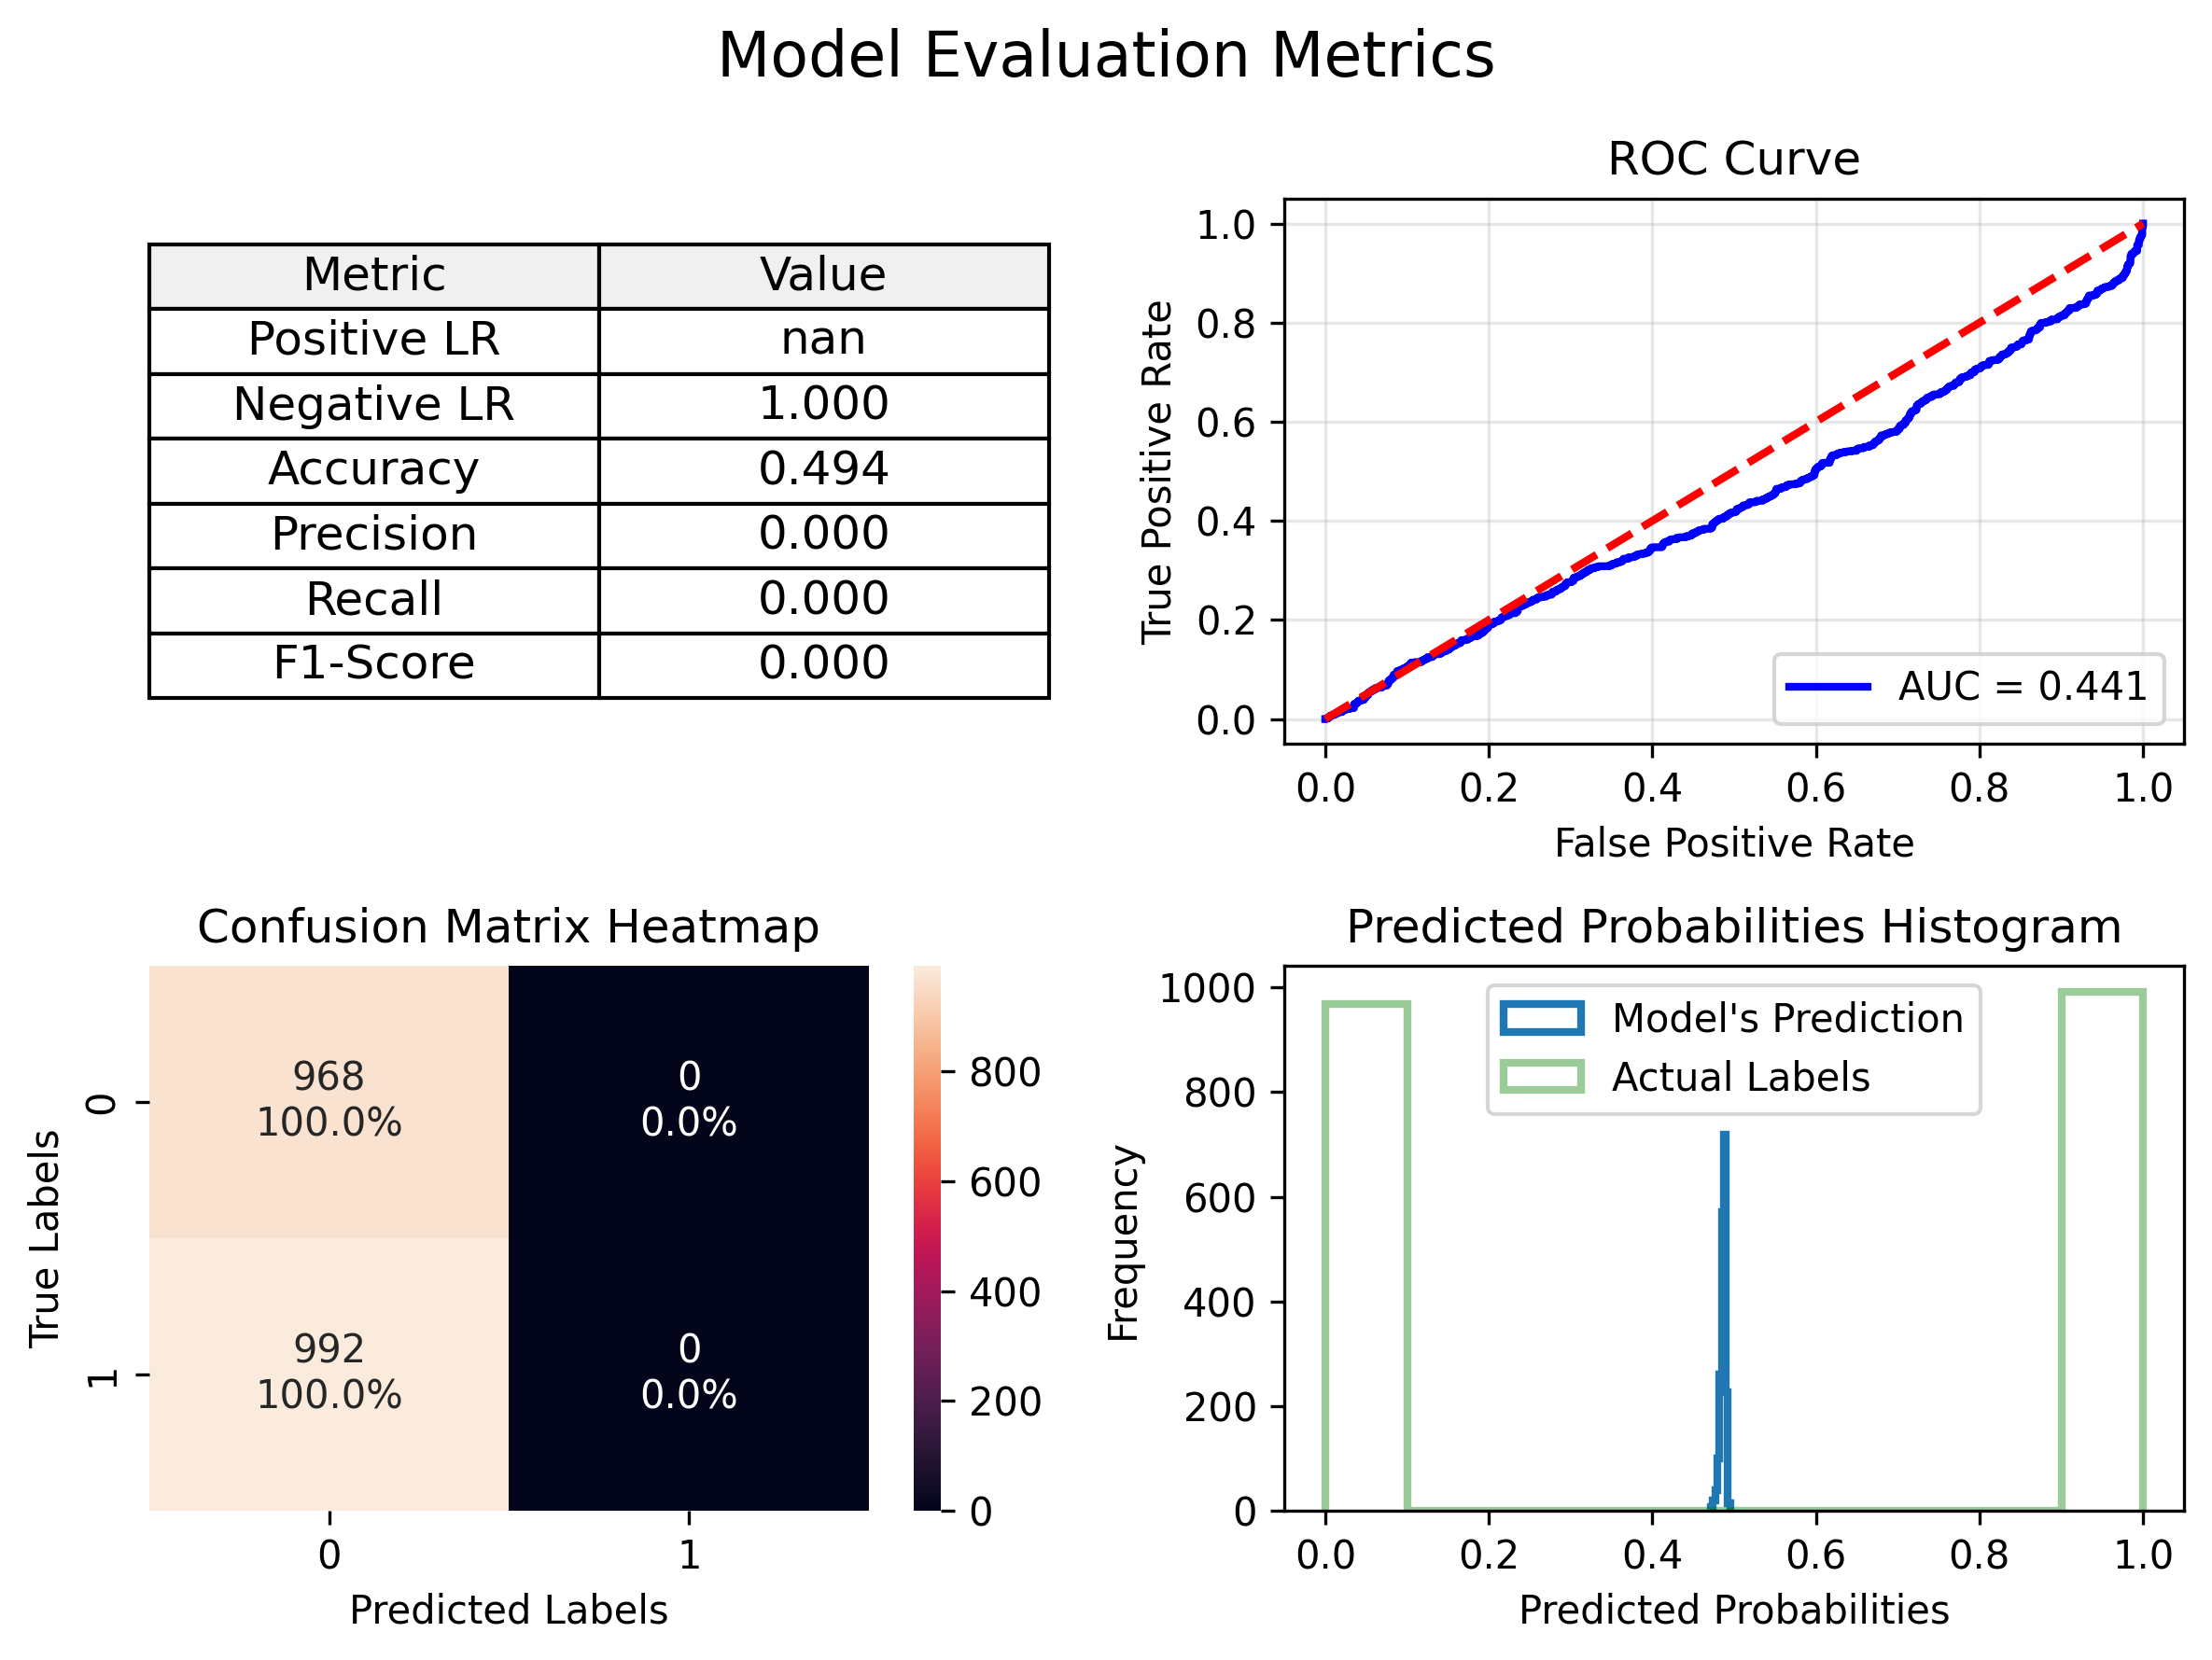

In [40]:
y_test_true, y_test_pred_prob = get_labels(AugData_model, test)
y_test_pred_label = [1 if (y_pred >= 0.5) else 0 for y_pred in y_test_pred_prob]
eval_model(y_test_true, y_test_pred_prob, y_test_pred_label, save_fig = False, 
           save_fig_path = 'Classifier_with_DataAugmentation_model_Metrics.png')